## Multi-classification problem

__Note:__ you might need to do
`conda install torchvision "pillow<7"`
if torchvision is not already installed on your computer, and/or for compatibility issues (the version of torchvision version supporting the last version of Pillow is not released yet).

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split


import matplotlib.pyplot as plt

%matplotlib inline

### [MNIST Dataset](https://pytorch.org/docs/stable/torchvision/datasets.html#mnist)
* Handwritten digits with 10 classes
* the size of each image is 28x28 pixels 
* 50 000 data examples in training set, 10 000 examples in validation set, 10 000 in test set

In [2]:
# Loading MNIST dataset from torchvision.dataset
dataset = torchvision.datasets.MNIST(root='data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

100.1%

Extracting data/MNIST\raw\train-images-idx3-ubyte.gz to data/MNIST\raw


0.0%

113.5%

Extracting data/MNIST\raw\train-labels-idx1-ubyte.gz to data/MNIST\raw


100.4%

Extracting data/MNIST\raw\t10k-images-idx3-ubyte.gz to data/MNIST\raw


180.4%

Extracting data/MNIST\raw\t10k-labels-idx1-ubyte.gz to data/MNIST\raw
Processing...
Done!


In [3]:
print("The shape of the dataset is :", dataset.data.size())

The shape of the dataset is : torch.Size([60000, 28, 28])


In [4]:
# split the dataset to training and validation sets
train_set, val_set = random_split(dataset, [50000, 10000])

Text(0.5, 1.0, 'image label: 0')

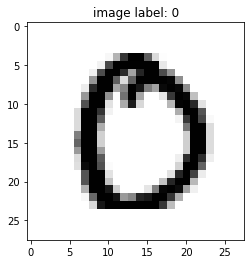

In [5]:
sample_index = 88

plt.imshow(dataset.data[sample_index], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("image label: %d" % dataset.targets[sample_index])

### Training the neural network

In [14]:
gpu = None
cpu = torch.device("cpu")
if torch.cuda.is_available():
    gpu = torch.device("cuda:0")
if gpu: print("GPU available")

GPU available


In [30]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.l1 = nn.Linear(28*28, 10)# Input size is 28*28, output size should be the same with the number of classes
        
    def forward(self, inputs):
        outputs = F.softmax(self.l1(inputs), dim=1)# Use softmax as the activation function for the last layer
        
        return outputs

In [60]:
# Create the model: 
model = Model()

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 128

# Use mean squared loss function 
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [61]:
# define a function for training
def train(num_epochs, batch_size, criterion, optimizer, model, dataset):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True, drop_last=True)
    if gpu:
        model.to(gpu)
    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            if gpu:
                images, labels = images.to(gpu), labels.to(gpu)
            y_pre = model(images.view(batch_size, -1)) 
            #reshape the inputs from [N, img_shape, img_shape] to [N, img_shape*img_shape] 
            
            # One-hot encoding or labels so as to calculate MSE error:
            labels_one_hot = torch.FloatTensor(batch_size, 10)
            if gpu:
                labels_one_hot = labels_one_hot.to(gpu)
            labels_one_hot.zero_()
            labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
           
            
            loss = criterion(y_pre, labels_one_hot)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
    if gpu:
        model.to(cpu)
    return train_error

In [62]:
train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)

Epoch [1/10], Loss: 0.0895
Epoch [2/10], Loss: 0.0875
Epoch [3/10], Loss: 0.0853
Epoch [4/10], Loss: 0.0828
Epoch [5/10], Loss: 0.0802
Epoch [6/10], Loss: 0.0774
Epoch [7/10], Loss: 0.0747
Epoch [8/10], Loss: 0.0719
Epoch [9/10], Loss: 0.0692
Epoch [10/10], Loss: 0.0665


Text(0.5, 1.0, 'Visualization of convergence')

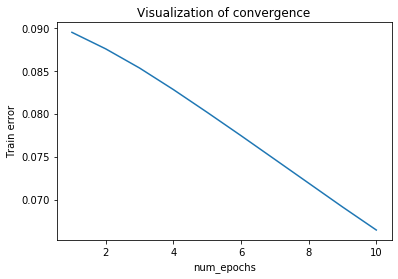

In [63]:
# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

### Evaluate the Model on validation set

In [87]:
# Calculate the accuracy to evaluate the model
def compute_acc(dataset, model):
    if gpu:
        model.to(gpu)
    with torch.no_grad():
        correct = 0
        total = 0
        dataloader = DataLoader(dataset)
        for images, labels in dataloader:
            images, labels = images.to(gpu), labels.to(gpu)
            images = images.view(-1, 28*28)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1) 
            correct += (predicted == labels).sum()
    if gpu:
        model.to(cpu)
    return correct.item()/ len(dataset)

def accuracy(dataset, model):
    acc = compute_acc(dataset, model)
    print('Accuracy of the model : {:.2f} %'.format(100*acc))

In [88]:
accuracy(val_set, model)

C:\Users\sbran\Anaconda3\envs\adl\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the model : 45.55 %


Text(0.5, 1.0, 'Prediction label: 1')

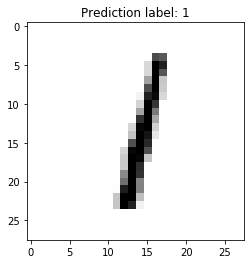

In [66]:
val_index = 66

(image, label) = val_set[val_index]
output = model(image.view(-1, 28*28))
_, prediction = torch.max(output.data, 1)

plt.imshow(image.view(28, 28), cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("Prediction label: %d" % prediction)

### Exercise 1: Impact of the architecture of the model
Define your own class `Model` to improve the predictions:

* The convolutional layer can be a good choice to deal with images. Replace nn.Linear with [nn.Conv2d](https://pytorch.org/docs/stable/nn.html#conv2d).
* Try to add more layers (1, 2, 3, more ?)
* Change the number of neurons in hidden layers (5, 10, 20, more ?)
* Try different activation functions such as [sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.

In [78]:
class CustomModel(nn.Module):
    
    def __init__(self, hidden_layers=1, hidden_neurons=128, hidden_activation=torch.relu):
        super().__init__()
        self.n_hidden_layers = hidden_layers
        self.hidden_activation = hidden_activation
        
        self.layers_input = [28*28]
        
        for i in range(hidden_layers):
            setattr(self,
                    "hidden_{}".format(i),
                    nn.Linear(self.layers_input[-1], hidden_neurons))
            self.layers_input.append(hidden_neurons)
        
        self.output = nn.Linear(self.layers_input[-1], 10)
    
    def forward(self, x):
        for i in range(self.n_hidden_layers):
            layer = getattr(self, "hidden_{}".format(i))
            x = self.hidden_activation(layer(x))
        x = F.softmax(self.output(x), dim=1)
        return x


In [89]:
def train_eval(epochs=10, batch_size=128, 
               criterion=nn.MSELoss, optimizer=torch.optim.SGD, lr=0.01, 
               opt_kwargs={},
               criterion_kwargs={},
               model_kwargs={}):
    # Create model instance
    model = CustomModel(**model_kwargs)
    criterion = criterion(**opt_kwargs)
    optimizer = optimizer(model.parameters(), lr=lr, **opt_kwargs)
    
    train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)
    val_acc = compute_acc(val_set, model)
    
    return train_error, val_acc

In [93]:
epochs = 10
batch_size = 512

model_kwargs = dict(hidden_layers=2, hidden_neurons=512)

train_error, val_acc = train_eval(epochs=epochs, batch_size=batch_size, 
                                  model_kwargs=model_kwargs)

# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence - Val. accuracy: {:.2f}%".format())

C:\Users\sbran\Anaconda3\envs\adl\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [1/10], Loss: 0.0894
Epoch [2/10], Loss: 0.0893
Epoch [3/10], Loss: 0.0893
Epoch [4/10], Loss: 0.0893
Epoch [5/10], Loss: 0.0893
Epoch [6/10], Loss: 0.0893
Epoch [7/10], Loss: 0.0893
Epoch [8/10], Loss: 0.0892
Epoch [9/10], Loss: 0.0892
Epoch [10/10], Loss: 0.0892


KeyboardInterrupt: 

C:\Users\sbran\Anaconda3\envs\adl\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Text(0.5, 1.0, 'Prediction label: 1')

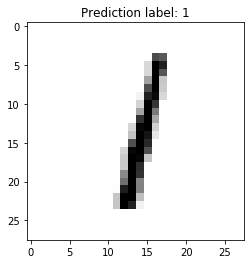

In [82]:
val_index = 66

(image, label) = val_set[val_index]
output = model(image.view(-1, 28*28))
_, prediction = torch.max(output.data, 1)

plt.imshow(image.view(28, 28), cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("Prediction label: %d" % prediction)

### Exercise 2: Impact of the optimizer
Retrain the model by using different parameters of the optimizer; you can change its parameters in the cell initializing it, after the definition of your model.

* Use different batch sizes, from 10 to 1 000 for instance
* Try different values of the learning rate (between 0.001 and 10), and see how these impact the training process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

### Exercise 3: Impact of the loss function
The MSE error is rarely used in this case. The cross entropy loss can be a better choice for multi-classification problems. In pytorch, the cross entropy loss is defined by [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#crossentropyloss). Replace the MSE loss by this one to observe its impact.

**Note:** In order to use nn.CrossEntropyLoss correctly, don't add an activation function to the last layer of your network. And one-hot encoding is no longer needed to calculate the loss, delete the encoding procedures in function `train`.   

### Exercise 4: Prediction on test set

Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.

In [ ]:
# Loading MNIST test set from torchvision.dataset
test_set = torchvision.datasets.MNIST(root='data/',
                                         train=False,
                                         transform=transforms.ToTensor(),
                                         download=False)

In [ ]:
accuracy(test_set, model)